<a href="https://colab.research.google.com/github/amishgog/exoplanet-search/blob/main/exoplanet_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all necessary modules
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [ ]:
#uploading train file
from google.colab import files
uploaded = files.upload()
filename_1 = next(iter(uploaded))

Saving trainpy.csv to trainpy.csv


In [ ]:
#importing test file
from google.colab import files
uploaded = files.upload()
filename_2 = next(iter(uploaded))

Saving testpy.csv to testpy.csv


In [ ]:
#formatting data for processing
train_data = pd.read_csv(filename_1)
test_data = pd.read_csv(filename_2)
test_data.head()
x_test=test_data.drop("LABEL",axis=1)

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

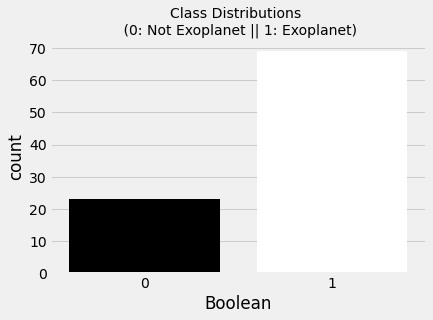

In [ ]:
#show difference in number of data points in train file
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot('Boolean', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)


In [ ]:
x_train = train_data.drop(["Boolean"],axis=1)
y_train = train_data["Boolean"]   
x_test.head()

,time__sum_values,time__median,time__mean,time__length,time__standard_deviation,time__variance,time__root_mean_square,time__maximum,time__absolute_maximum,time__minimum,...,cadenceno__absolute_maximum,cadenceno__minimum,quality__sum_values,quality__mean,quality__length,quality__standard_deviation,quality__variance,quality__root_mean_square,quality__maximum,quality__absolute_maximum
0,31262075.88,1696.345749,1696.812629,18424,7.894397,62.321504,1696.830994,1710.205982,1710.205982,1683.356226,...,347579,328247,2560,0.138949,18424,8.433426,7.112268e+01,8.434571,512,512
1,55682641.90,2839.311979,2839.212824,19612,8.094172,65.515614,2839.224362,2853.142897,2853.142897,2825.262717,...,1170492,1150418,16619008,847.389761,19612,4988.254952,2.488269e+07,5059.719051,32768,32768
2,53071554.06,2811.142211,2810.695586,18882,7.977072,63.633676,2810.706906,2824.267890,2824.267890,2797.105159,...,1149702,1130145,2560,0.135579,18882,8.330546,6.939799e+01,8.331649,512,512
3,1633199.97,1503.870692,1503.867375,1086,7.311641,53.460100,1503.885150,1516.078751,1516.078751,1491.662377,...,13853,12681,196608,181.038674,1086,2428.888690,5.899500e+06,2435.626258,32768,32768
4,1633199.97,1503.870692,1503.867375,1086,7.311641,53.460100,1503.885150,1516.078751,1516.078751,1491.662377,...,13853,12681,196608,181.038674,1086,2428.888690,5.899500e+06,2435.626258,32768,32768


In [ ]:
#normalizing data points in train and test files
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [ ]:
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

In [ ]:
#using PCA for finding useful features for training and testing
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
pca = PCA(n_components=k)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


In [ ]:
#sampling data to get equal number of 1s and 0s
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
sm = SMOTE(random_state=27, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 69
Before OverSampling, counts of label '0': 23 

After OverSampling, counts of label '1': 69
After OverSampling, counts of label '0': 69


In [ ]:
#applying model to train data by splitting
from sklearn.ensemble import RandomForestClassifier
rfor=RandomForestClassifier()
k_train,k_test,l_train,l_test=train_test_split(x_train_res,y_train_res,test_size=0.2,random_state=39)
rfor.fit(k_train,l_train)
print("Accuracy before tuning:",rfor.score(k_test,l_test))

Accuracy before tuning: 0.8928571428571429


In [ ]:
#tuning data for getting better accuracy
from sklearn.model_selection import RandomizedSearchCV
rf_grid={"n_estimators":np.arange(200,500,5),
        "max_depth":[10],
        "min_samples_split":np.arange(10,15,1),
        "min_samples_leaf":np.arange(1,12,1)}
#Now we tune Random Forest 
np.random.seed(39)

rs_rf=RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=rf_grid,
                        cv=5,
                        n_iter=25,
                        verbose=True)
rs_rf.fit(k_train,l_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=25,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_split': array([10, 11, 12, 13, 14]),
                                        'n_estimators': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455,
       460, 465, 470, 475, 480, 485, 490, 495])},
                   verbose=True)

In [ ]:
#finding the best parameters 
rs_rf.best_params_

{'n_estimators': 335,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [ ]:
print("Accuracy after tuning:",rs_rf.score(k_test,l_test))

Accuracy after tuning: 0.9285714285714286


In [ ]:
#printing boolean result of analysis
test_preds=rs_rf.predict(x_test)
test_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [ ]:
#printing classfication report
y_preds2=rs_rf.predict(k_test)
print(classification_report(l_test,y_preds2))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.92      0.92      0.92        12

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



In [ ]:
#uloading final test file
from google.colab import files
uploaded = files.upload()
final_test_file = next(iter(uploaded))

Saving final_test_file (3).xlsx to final_test_file (3).xlsx


In [ ]:
#appending and creating new prediction file with boolean data
final_test = pd.read_excel(final_test_file)
st_preds=pd.DataFrame()
st_preds["starID"]=final_test["Star_ID"]
st_preds["Boolean"]=test_preds
st_preds
st_preds.to_csv('final_test_prediction.csv')


# New section